In [547]:
import Pkg; Pkg.add("Plots"); Pkg.add("BenchmarkTools"); Pkg.add("DelimitedFiles");

   Resolving package versions...
  No Changes to `C:\Users\michr\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\michr\.julia\environments\v1.6\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\michr\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\michr\.julia\environments\v1.6\Manifest.toml`
   Resolving package versions...
    Updating `C:\Users\michr\.julia\environments\v1.6\Project.toml`
  [8bb1440f] + DelimitedFiles
  No Changes to `C:\Users\michr\.julia\environments\v1.6\Manifest.toml`


In [185]:
import Pkg; Pkg.add("Plots")

   Resolving package versions...
  No Changes to `C:\Users\michr\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\michr\.julia\environments\v1.6\Manifest.toml`


In [530]:
import Pkg; Pkg.add("PyPlot")

   Resolving package versions...
   Installed PyPlot ─ v2.9.0
   Installed PyCall ─ v1.92.3
    Updating `C:\Users\michr\.julia\environments\v1.6\Project.toml`
  [d330b81b] + PyPlot v2.9.0
    Updating `C:\Users\michr\.julia\environments\v1.6\Manifest.toml`
  [438e738f] + PyCall v1.92.3
  [d330b81b] + PyPlot v2.9.0
    Building PyCall → `C:\Users\michr\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\169bb8ea6b1b143c5cf57df6d34d022a7b60c6db\build.log`
Precompiling project...
  ✓ PyCall
  ✓ PyPlot
2 dependencies successfully precompiled in 9 seconds (188 already precompiled)


In [37]:
import BenchmarkTools

In [38]:
import Pkg; Pkg.add("NNlib");

   Resolving package versions...
  No Changes to `C:\Users\michr\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\michr\.julia\environments\v1.6\Manifest.toml`


In [39]:
# Definicja struktury Dual
struct Dual{T <:Number} <:Number
     v::T
    dv::T
end

In [40]:
# Przeciążanie operatorów i funkcji

import Base: +, -, *, /, ^
-(x::Dual)          = Dual(-x.v,       -x.dv)
+(x::Dual, y::Dual) = Dual( x.v + y.v,  x.dv + y.dv)
-(x::Dual, y::Dual) = Dual( x.v - y.v,  x.dv - y.dv)
*(x::Dual, y::Dual) = Dual( x.v * y.v,  x.dv * y.v + x.v * y.dv)
/(x::Dual, y::Dual) = Dual( x.v / y.v, (x.dv * y.v - x.v * y.dv)/y.v^2)
^(x::Dual, y::Dual) = Dual(x.v^y.v, (y.v*(x.v^(y.v - 1.0))))

import Base: abs, sin, cos, tan, exp, sqrt, isless
sin(x::Dual)  = Dual(sin(x.v), cos(x.v)*x.dv)
cos(x::Dual)  = Dual(cos(x.v),-sin(x.v)*x.dv)
abs(x::Dual)  = Dual(abs(x.v),sign(x.v)*x.dv)
tan(x::Dual)  = Dual(tan(x.v), one(x.v)*x.dv + tan(x.v)^2*x.dv)
exp(x::Dual)  = Dual(exp(x.v), exp(x.v)*x.dv)
sqrt(x::Dual) = Dual(sqrt(x.v),.5/sqrt(x.v) * x.dv)
isless(x::Dual, y::Dual) = x.v < y.v;

# Zdefiniowanie zarodka
ϵ = Dual(0.0, 1.0)

(0.0) + [1.0ϵ]

In [43]:
# Konwersja i promocja typów
import Base: convert, promote_rule

In [44]:
convert(::Type{Dual{T}}, x::Dual) where T = Dual(convert(T, x.v), convert(T, x.dv))
@show Dual{Float64}[Dual(1,2), Dual(3,0)];

Dual{Float64}[Dual(1, 2), Dual(3, 0)] = Dual{Float64}[(1.0) + [2.0ϵ], (3.0) + [0.0ϵ]]


In [45]:
convert(::Type{Dual{T}}, x::Number) where T = Dual(convert(T, x), zero(T))
@show Dual{Float64}[1, 2, 3];

Dual{Float64}[1, 2, 3] = Dual{Float64}[(1.0) + [0.0ϵ], (2.0) + [0.0ϵ], (3.0) + [0.0ϵ]]


In [46]:
promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} = Dual{promote_type(T,R)}
@show Dual(1,2) * 3;

Dual(1, 2) * 3 = (3) + [6ϵ]


In [47]:
# Redefinicja wyświetlania wyniku
import Base: show
show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ϵ]");

In [48]:
# Funkcja, która wyciąga część odpowiadającą za pochodną z liczby dualnej
partials(x::Dual) = x.dv
# Funkcja, która wyciąga część rzeczywistą z liczby dualnej
value(x::Dual) = x.v

value (generic function with 1 method)

In [49]:
using BenchmarkTools

In [50]:
# Definicja funkcji softmax
softmax(x)  =  exp.(x) ./ sum(exp.(x));



In [51]:
# Definicja funkcji zwracającej macierz Jacobiego
J = function jacobian(f, args::Vector{T}) where {T <:Number}
    jacobian_columns = Matrix{T}[]
    
    for i=1:length(args)
        x = Dual{T}[]
        for j=1:length(args)
            seed = (i == j)
            push!(x, seed ?
                Dual(args[j], one(args[j])) :
                Dual(args[j],zero(args[j])) )
        end
        column = partials.([f(x)...])
        push!(jacobian_columns, column[:,:]);
    end
    #println(jacobian_columns)
    hcat(jacobian_columns...)
end

jacobian (generic function with 1 method)

In [52]:
# Funkcje aktywacji: ReLu, f.sigmoidalna, tangens hiperboliczny
ReLU(x) = max(zero(x), x)
σ(x) = one(x) / (one(x) + exp(-x))
tanh(x) = 2.0 / (one(x) + exp(-2.0x)) - one(x)

tanh (generic function with 1 method)

In [53]:
#FUNKCJE OBLICZENIOWE
# 1) Potęgowanie
# 2) Funkcja wykładnicza
# 3) Funkcja sinus/cosinus
# 4) Funkcja ReLu
# 5) Funkcja softmax

In [54]:
# Ad 1 - Potęgowania (f. jednoargumentowa)
y = 2
x = rand(10)
f(x) = y^x
# Obliczenie wektora pochodnych funkcji potęgowania dla wektora argumentów + Benchmark
@btime y = partials.(f.($x .+ ϵ))

  3.250 μs (47 allocations: 1.59 KiB)


10-element Vector{Float64}:
 0.629314965040426
 0.09507700840252527
 0.953968963800077
 0.05064176111157396
 0.4164247116235913
 0.280137742621393
 0.256393973587004
 0.03983798808665227
 0.8223853347335053
 0.21502047862026272

In [617]:
# Ad 2 - Funkcja wykładnicza (f. jednoargumentowa)
x = randn(100)
f(x) = exp(x)
# Obliczenie wektora pochodnych funkcji wykładniczej dla wektora argumentów + Benchmark
#@btime y = partials.(f.($x .+ ϵ))
y = @benchmark partials.(f.($x .+ ϵ))
#mean(y.times)

BenchmarkTools.Trial: 
  memory estimate:  1.27 KiB
  allocs estimate:  11
  --------------
  minimum time:     2.311 μs (0.00% GC)
  median time:      2.589 μs (0.00% GC)
  mean time:        2.660 μs (2.03% GC)
  maximum time:     546.356 μs (99.08% GC)
  --------------
  samples:          10000
  evals/sample:     9

In [618]:
# Ad 3.1 -  Funkcja sinus (f.jednoargumentowa)
x = rand(Float64,10)
f(x) = sin(x)
#Obliczenie wektora pochodnych funkcji sinus dla wektora argumentów x + Benchmark
#@btime y = partials.(f.($x .+ ϵ))

y = @benchmark partials.(f.($x .+ ϵ))
#mean(y.times)

BenchmarkTools.Trial: 
  memory estimate:  560 bytes
  allocs estimate:  11
  --------------
  minimum time:     1.540 μs (0.00% GC)
  median time:      1.650 μs (0.00% GC)
  mean time:        1.701 μs (0.00% GC)
  maximum time:     8.710 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     10

In [620]:
# Ad 3.2 - Funkcja cosinus (f.jednoargumentowa)
x = rand(Float64,10)
f(x) = cos(x)
#Obliczenie wektora pochodnych funkcji cosinus dla wektora argumentów x + Benchmark
#@btime y = partials.(f.($x .+ ϵ))

y = @benchmark partials.(f.($x .+ ϵ))
#mean(y.times)

BenchmarkTools.Trial: 
  memory estimate:  560 bytes
  allocs estimate:  11
  --------------
  minimum time:     1.460 μs (0.00% GC)
  median time:      1.570 μs (0.00% GC)
  mean time:        1.627 μs (0.00% GC)
  maximum time:     7.480 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     10

In [621]:
# Funkcja złożona sin(x^2)
x = rand(Float64, 10)
f(x) = sin(x^2)
y = @benchmark partials.(f.($x .+ ϵ))
#mean(y.times)

BenchmarkTools.Trial: 
  memory estimate:  560 bytes
  allocs estimate:  11
  --------------
  minimum time:     1.540 μs (0.00% GC)
  median time:      1.660 μs (0.00% GC)
  mean time:        1.776 μs (0.00% GC)
  maximum time:     10.020 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     10

In [614]:
# Ad 4- Funkcja ReLU - przedstawiona na dwa sposoby
#(1) 
ReLu(x) = max(zero(x), x)
x = -1.0:0.5:+1.0
#Obliczenie wektora pochodnych funkcji ReLu dla wektora argumentów x + Benchmark
@btime y = partials.(ReLu.($x .+ ϵ))

#(2)
f(x) = x > zero(x) ? x : zero(x)
x = -1.0:0.1:+1.0
y = @benchmark partials.(f.($x .+ ϵ))

  1.370 μs (11 allocations: 848 bytes)


BenchmarkTools.Trial: 
  memory estimate:  976 bytes
  allocs estimate:  11
  --------------
  minimum time:     1.280 μs (0.00% GC)
  median time:      1.400 μs (0.00% GC)
  mean time:        1.546 μs (0.00% GC)
  maximum time:     7.800 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     10

In [608]:
# Ad 5 - Funkcja softmax
ϵ = Dual(0.0, 1.0)
x = rand(Float64, 6)
@btime y = partials.(softmax($x .+ ϵ))

  1.130 μs (9 allocations: 784 bytes)


6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [450]:
# Różniczkowanie dla funkcji przyjmującej dwa parametry - przykład dla f.sinus
derivative(f, x) = partials(f(Dual(x, one(x))))
f(x,y)= sin(x*y)
x = 10.0
y = 25.0

# Pochodna cząstkowa funkcji f po x (df/dx) ; pochodna cząstkowa funkcji f po y (df/dy)
derivative(a -> f(a, 25.0), 10.0) # df/dx
derivative(a -> f(10.0, a), 25.0) # df/dy



6.024707632131466

In [62]:
# Wyznaczenie macierzy Jacobiego dla poszczególnych funkcji
# 1. Sinus/cosinus
# 2. Funkcja wykładnicza
# 3. Funkcja softmax
# 4. Funkcja ReLu 

In [544]:
#Ad 1 - Sinus
# funkcja jacobian zwraca macierz pochodnych cząstkowych funkcji f, czyli macierz [df/dx df/dy]
# sin(x[1]*x[2]) jest równoznaczne z sin(x * y)
vector = [2.0, 4.0]
f(x::Vector) = sin(x[1] * x[2])
@btime jacobian(f,vector)

  428.283 ns (13 allocations: 1.09 KiB)


1×2 Matrix{Float64}:
 -0.582  -0.291

In [65]:
# Ad 1 - cosinus
vector = rand(Float64,2)
println(vector)
f(x::Vector) = cos(x[1] * x[2])
@btime jacobian(f,vector)

[0.14966895115095524, 0.991247729976666]
  417.588 ns (13 allocations: 1.09 KiB)


1×2 Matrix{Float64}:
 -0.146522  -0.0221234

In [432]:
# Ad 2 - funkcja wykładnicza
vector = [1.0, 2.0, 4.0]
println(vector)
f(x::Vector) = exp(x[1]*x[2]*x[3])
@btime jacobian(f,vector)

[1.0, 2.0, 4.0]
  862.222 ns (20 allocations: 1.61 KiB)


1×3 Matrix{Float64}:
 23847.7  11923.8  5961.92

In [67]:
# Ad 3 - funkcja softmax użyta jako argument funkcji jacobian - zwracającej macierz Jacobiego
vector = rand(Float64, 5)
f(x::Vector) = softmax(x)
@btime jacobian(f, vector)

  4.271 μs (86 allocations: 6.75 KiB)


5×5 Matrix{Float64}:
  0.130214   -0.0251615  -0.0463545  -0.0339701  -0.0247278
 -0.0251615   0.136764   -0.0492445  -0.036088   -0.0262695
 -0.0463545  -0.0492445   0.210479   -0.0664842  -0.0483958
 -0.0339701  -0.036088   -0.0664842   0.172008   -0.0354661
 -0.0247278  -0.0262695  -0.0483958  -0.0354661   0.134859

In [68]:
# Ad 4 - funkcja ReLu - "przepuszczona" przez funkcję jacobian
vector = rand(Float64, 10)
println(vector)
f(x::Vector) = ReLu(x)
@btime jacobian(f, vector)

[0.915611869736974, 0.30341102043420065, 0.804883250105225, 0.19991283043648944, 0.0713416953472148, 0.30004060140745814, 0.5287664823765961, 0.49400889888541677, 0.7912705579708659, 0.13783748035275134]
  8.800 μs (217 allocations: 18.59 KiB)


10×10 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0

In [631]:
# Wywołanie funkcji jacobian stosując jako argument funkcję sin(x). 
f(x::Vector) = sin.(x)
jacobian(f,rand(Float64,5))


5×5 Matrix{Float64}:
 0.883902  0.0       0.0       0.0       0.0
 0.0       0.622426  0.0       0.0       0.0
 0.0       0.0       0.553729  0.0       0.0
 0.0       0.0       0.0       0.713685  0.0
 0.0       0.0       0.0       0.0       0.975552

In [485]:
# Liczenie błędu sieci

mean_squared_loss(y::Vector, ŷ::Vector) = sum(0.5(y - ŷ).^2)
fullyconnected(w::Vector, n::Number, m::Number, v::Vector, activation::Function) = activation.(reshape(w, n, m) * v)
Wh  = randn(10,2)
Wo  = randn(1,10)
dWh = similar(Wh)
dWo = similar(Wo)
x = [1.98;4.434]
y = [0.064]
E = Float64[]

function net(x, wh, wo, y)
    x̂ = fullyconnected(wh, 10, 2, x, σ)
    ŷ = fullyconnected(wo, 1, 10, x̂, u->u)
    E = mean_squared_loss(y, ŷ)
    
end
Ei = net(x, Wh[:], Wo[:], y)


0.838975060900453

In [486]:
dnet_Wh(x, wh, wo, y) = J(w -> net(x, w, wo, y), wh);
dnet_Wo(x, wh, wo, y) = J(w -> net(x, wh, w, y), wo);


#push!(E, Ei)


i = 1
error = Float64[]
while i <= 10
    
    push!(E, Ei)
    dWh[:] = dnet_Wh(x, Wh[:], Wo[:], y);
    dWo[:] = dnet_Wo(x, Wh[:], Wo[:], y);
    Wh -= 0.1dWh
    Wo -= 0.1dWo

    Ei  = net(x, Wh[:], Wo[:], y)
    i += 1
    
    println("Current loss: ", Ei)
end
println("wektor błędów", E)

Current loss: 0.0847427875436946
Current loss: 0.007432918640125676
Current loss: 0.0006283031780299048
Current loss: 5.257990739220367e-5
Current loss: 4.387502920311347e-6
Current loss: 3.658079479989435e-7
Current loss: 3.049189052703089e-8
Current loss: 2.5414723755141596e-9
Current loss: 2.1182524822933536e-10
Current loss: 1.765499258571549e-11
wektor błędów[0.838975060900453, 0.0847427875436946, 0.007432918640125676, 0.0006283031780299048, 5.257990739220367e-5, 4.387502920311347e-6, 3.658079479989435e-7, 3.049189052703089e-8, 2.5414723755141596e-9, 2.1182524822933536e-10]


In [433]:
mean_squared_loss(y::Vector, ŷ::Vector) = sum(0.5(y - ŷ).^2)
fullyconnected(w::Vector, n::Number, m::Number, v::Vector, activation::Function) = activation.(reshape(w, n, m) * v)


function net(x, wh, wo, y)
    x̂ = fullyconnected(wh, 10, 2, x, σ)
    ŷ = fullyconnected(wo, 1, 10, x̂, u->u)
    #println(x)
    E = mean_squared_loss(y, ŷ)
end
#Ei = net(x, Wh[:], Wo[:], y)
#println("Initial loss: ", Ei)

function net_error()
    i = 1
    
    Err = Float64[]
    while i <= 30
    
        Wh  = randn(10,2)
        Wo  = randn(1,10)
        dWh = similar(Wh)
        dWo = similar(Wo)
        x = [1.98;4.434]
        y = [0.2]
        E = Float64[]

        i += 1
        Ei = net(x, Wh[:], Wo[:], y)
        #println("Initial loss: ", Ei)
        push!(Err, Ei)
        #print(Err)
    end
end
a = @benchmark net_error()
#print(Err)


BenchmarkTools.Trial: 
  memory estimate:  74.67 KiB
  allocs estimate:  725
  --------------
  minimum time:     35.400 μs (0.00% GC)
  median time:      40.300 μs (0.00% GC)
  mean time:        53.572 μs (14.82% GC)
  maximum time:     10.752 ms (99.22% GC)
  --------------
  samples:          10000
  evals/sample:     1

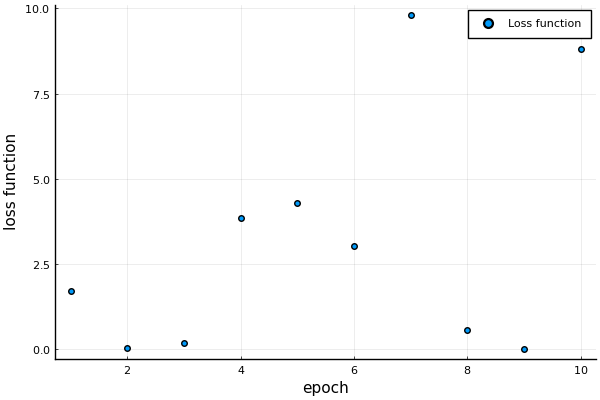

In [534]:
using Plots
x = [1:10]
plot(x, Err, line=nothing, label = "Loss function", marker=:circle)
xaxis!("epoch")
yaxis!("loss function")

In [ ]:
# Testy z użyciem modułu BenchmarkTools na potrzeby raportu

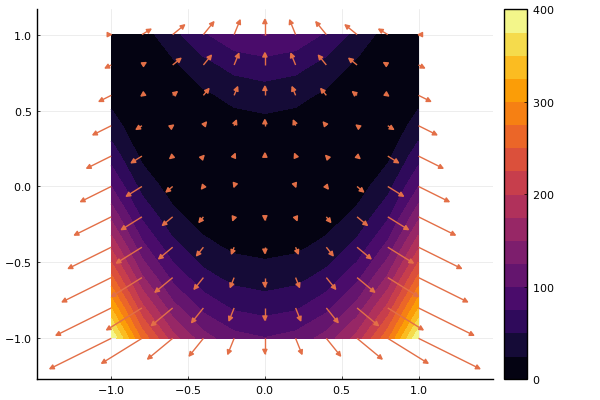

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [542]:
# Funkcja rosenbrocka
rosenbrock(x, y) = (1.0 - x*x) + 100.0*(y - x*x)*(y -x*x)

function rosenbrock_gradient()
    v = -1:0.2:+1
    n = length(v)
    xv = repeat(v, inner = n)
    yv = repeat(v, outer = n)

    z = rosenbrock.(xv .+ ϵ, yv)
    dx = 5e-4partials.(z)
    z = rosenbrock.(xv, yv .+ ϵ)
    dy = 5e-4partials.(z)
    zv = value.(z)
end

using Plots
zv = reshape(zv, n, n)
contour(v, v, zv, fill = true)
quiver!(xv[:], yv[:], gradient=(dx, dy))

In [630]:
# Obliczenie gradientu funkcji rosenbrocka - testy BenchmarkTools
a = @benchmark rosenbrock_gradient()

BenchmarkTools.Trial: 
  memory estimate:  11.91 KiB
  allocs estimate:  26
  --------------
  minimum time:     4.014 μs (0.00% GC)
  median time:      4.300 μs (0.00% GC)
  mean time:        6.149 μs (8.78% GC)
  maximum time:     519.829 μs (98.47% GC)
  --------------
  samples:          10000
  evals/sample:     7

In [629]:
a.times

10000-element Vector{Float64}:
   4042.8571428571427
   4057.1428571428573
   4057.1428571428573
   4057.1428571428573
   4057.1428571428573
   4057.1428571428573
   4057.1428571428573
   4057.1428571428573
   4071.4285714285716
   4071.4285714285716
   4071.4285714285716
   4071.4285714285716
   4071.4285714285716
      ⋮
  26728.571428571428
 433671.4285714286
 445657.14285714284
 452185.71428571426
 453085.71428571426
 453785.71428571426
 453885.71428571426
 456028.5714285714
 460271.4285714286
 476585.71428571426
 485757.14285714284
 505028.5714285714

In [565]:
forward_mean = []


Any[]

In [585]:
# Obliczanie macierzy pochodnych funkcji sinus za pomocą Jacobiana
vector = rand(Float64, 2)
f(x::Vector) = sin(x[1] * x[2])
b = @benchmark jacobian(f,vector)

#mean_times = mean(b.times)
#push!(forward_mean, mean_times)

BenchmarkTools.Trial: 
  memory estimate:  69.88 KiB
  allocs estimate:  1118
  --------------
  minimum time:     17.500 μs (0.00% GC)
  median time:      20.000 μs (0.00% GC)
  mean time:        28.251 μs (23.34% GC)
  maximum time:     6.785 ms (99.41% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [624]:
mean_t_reverse = [457.60120331950196, 744.0609090909091, 1079.5298648648647, 1412.328, 1859.418, 2247.663, 2642.8422222222225, 3008.519999999999, 3400.8355555555554, 3935.27, 4670.15625, 5443.152857142856, 6507.871666666667, 7750.98, 8253.9375]
mean_t_forward = [597.551959798995, 1620.559, 2388.411, 3215.5188888888893, 4435.94625, 5350.0375, 6563.025714285715, 7556.823333333331, 9988.158, 16221.45, 18027.82, 20504.02, 21734.13, 25530.39, 28120.19]

15-element Vector{Float64}:
   597.551959798995
  1620.559
  2388.411
  3215.5188888888893
  4435.94625
  5350.0375
  6563.025714285715
  7556.823333333331
  9988.158
 16221.45
 18027.82
 20504.02
 21734.13
 25530.39
 28120.19

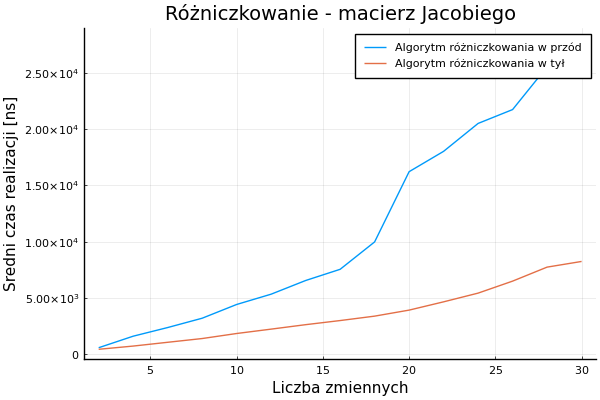

In [625]:
using Plots
x = [2:2:30]
plot(x, mean_t_forward, title = "Różniczkowanie - macierz Jacobiego", label = "Algorytm różniczkowania w przód" )
plot!(x, mean_t_reverse, label = "Algorytm różniczkowania w tył")
xaxis!("Liczba zmiennych")
yaxis!("Sredni czas realizacji [ns]")

In [586]:
forward_mean

15-element Vector{Any}:
   597.551959798995
  1620.559
  2388.411
  3215.5188888888893
  4435.94625
  5350.0375
  6563.025714285715
  7556.823333333331
  9988.158
 16221.45
 18027.82
 20504.02
 21734.13
 25530.39
 28120.19